In [1]:
import numpy
import os
from struct import unpack
import matplotlib.pyplot as plt
import numpy as np
import colorsys
from matplotlib.widgets import Slider, Button, RadioButtons
from tkinter import *
from ipywidgets import *
from IPython.display import display

In [2]:
def loadMtbFileStructure(fileName):
    f = open(fileName, "rb")
    try:
        fileNameLenghtBytes = f.read(4)  
        fileNameLenghtNode = unpack('i', fileNameLenghtBytes)
        fileNameLenght = sum(fileNameLenghtNode)
        fileName = loadFileNameStructure(f.read(fileNameLenght).decode("utf-8"))

        dateLenghtBytes = f.read(4)
        dateLenghtNode = unpack('i', dateLenghtBytes)
        dateLenght = sum(dateLenghtNode)
        date = f.read(dateLenght).decode("utf-8")
        
        notesLenghtBytes = f.read(4)
        notesLenghtNode = unpack('i', notesLenghtBytes)
        notesLenght = sum(notesLenghtNode)
        notes = f.read(notesLenght).decode("utf-8")
        f.read(16)
        
        dataPacketsLenghtBytes = f.read(4)
        dataPacketsLenghtNode = unpack('i', dataPacketsLenghtBytes)
        dataPacketsLenght = sum(dataPacketsLenghtNode)
        dataPackets = []
        for i in range(0, dataPacketsLenght):
            dataPacket = loadDataPacketStructure(f.read(24))
            dataPackets.append(dataPacket)
    finally:
        f.close()
    mtbFile = Mtb(fileName, date, notes, dataPackets)
    return mtbFile

def loadDataPacketStructure(dataPacketBytes):
    momentPomiaru = sum(unpack('i', dataPacketBytes[0:4]))
    polozenieX = sum(unpack('i', dataPacketBytes[4:8]))
    polozenieY = sum(unpack('i', dataPacketBytes[8:12]))
    nacisk = sum(unpack('i', dataPacketBytes[12:16]))
    szerokoscKatowa = sum(unpack('i', dataPacketBytes[16:20]))
    wysokoscKatowa = sum(unpack('i', dataPacketBytes[20:24]))
    return PakietDanych(momentPomiaru, polozenieX, polozenieY, nacisk, szerokoscKatowa, wysokoscKatowa)
    

def loadFileNameStructure(fileNameString):
    lp = fileNameString[:fileNameString.find('_', 0)]
    tmp = fileNameString.find('_', len(lp)+1)
    idPacjenta = fileNameString[len(lp)+1:tmp]
    nrOperacji = fileNameString[tmp+1]
    badanie = fileNameString[tmp+2]
    plec = fileNameString[tmp+3]
    reka = fileNameString[tmp+4]
    polkula = fileNameString[tmp+5]
    zabieg = fileNameString[tmp+6]
    return NazwaPliku(lp, idPacjenta, nrOperacji, badanie, plec, reka, polkula, zabieg)

In [14]:
class PakietDanych(object):
    momentPomiaru = 0.0
    polozenieX = 0.0
    polozenieY = 0.0
    nacisk = 0.0
    szerokoscKatowa = 0.0
    wysokoscKatowa = 0.0
    
    def __init__(self, momentPomiaru, polozenieX, polozenieY, nacisk, szerokoscKatowa, wysokoscKatowa):
        self.momentPomiaru = momentPomiaru
        self.polozenieX = polozenieX
        self.polozenieY = polozenieY
        self.nacisk = nacisk
        self.szerokoscKatowa = szerokoscKatowa
        self.wysokoscKatowa = wysokoscKatowa

    
class NazwaPliku(object):
    lp = -1
    idPacjenta = -1
    nrOperacji = -1
    badanie = -1
    plec = ''
    reka = ''
    polkula = ''
    zabieg = ''
    
    def __init__(self, lp, idPacjenta, nrOperacji, badanie, plec, reka, polkula, zabieg):
        self.lp = lp
        self.idPacjenta = idPacjenta
        self.nrOperacji = nrOperacji
        self.badanie = badanie
        self.plec = plec
        self.reka = reka
        self.polkula = polkula
        self.zabieg = zabieg
        
class Mtb(object):
    nazwaPliku = object
    data = ''
    notatki = ''
    pakietyDanych = []    
    def __init__(self, nazwaPliku, data, notatki, pakietyDanych):
        self.nazwaPliku = nazwaPliku
        self.data = data
        self.notatki = notatki
        #self.pakietyDanych = mergeSort(pakietyDanych)
        #self.pakietyDanych = pakietyDanych
        pakietyDanych.sort(key=lambda x: x.momentPomiaru, reverse=False)

        # To return a new list, use the sorted() built-in function...
        self.pakietyDanych = sorted(pakietyDanych, key=lambda x: x.momentPomiaru, reverse=False)
    def sortuj(self):
        for i in range(0, len(self.pakietyDanych)):
            flaga = False
            for j in range(0, len(self.pakietyDanych)-1):
                if self.pakietyDanych[j].momentPomiaru > self.pakietyDanych[j+1].momentPomiaru:
                    self.pakietyDanych[j], self.pakietyDanych[j+1] = swap(self.pakietyDanych[j], self.pakietyDanych[j+1])
                    flaga = True
            if not flaga:
                return
            
def swap(s1, s2):
    return s2, s1

In [15]:
def getAllMtbFilesFrom(folderName):
    mtbFiles = []
    for name in os.listdir(folderName):
        if name.endswith('.mtb') and os.path.isfile(folderName + '/' + name):
            mtbFile = loadMtbFileStructure(folderName + '/' + name)
            mtbFiles.append(mtbFile)
        elif os.path.isdir(folderName + '/' + name):
            mtbFiles += getAllMtbFilesFrom(folderName + '/' + name)
    return mtbFiles

In [16]:
def getColorForPlot(nacisk, minValue):
    #0 - wysoki nacisk
    #1/3 - niski nacisk
    #value przyjmuje wartosci 0-1023 (0 - niski nacisk, 1023 - wysoki nacisk)
    #Jeśli nacisk jest mniejszy niż minimalny dopuszczalny, to uznajemy, że nie rysował
    
    if minValue >= nacisk:
        return colorsys.hsv_to_rgb(0.0, 0.0, 0.0)
    nacisk /= 1024
    nacisk = 1 - nacisk
    nacisk /= 3
    return colorsys.hsv_to_rgb(nacisk, 1.0, 1.0)

In [44]:
mtbFiles = getAllMtbFilesFrom('./dane')#/33100000000 (M)
print(mtbFiles)

[<__main__.Mtb object at 0x118eeb8d0>, <__main__.Mtb object at 0x119589c50>, <__main__.Mtb object at 0x11998feb8>, <__main__.Mtb object at 0x11a750f98>, <__main__.Mtb object at 0x11b41bc50>, <__main__.Mtb object at 0x11c77bb38>, <__main__.Mtb object at 0x11ddf4ef0>, <__main__.Mtb object at 0x11e55feb8>, <__main__.Mtb object at 0x11e9267f0>, <__main__.Mtb object at 0x11f3f0a58>, <__main__.Mtb object at 0x120390e80>, <__main__.Mtb object at 0x120a89160>, <__main__.Mtb object at 0x121495b38>, <__main__.Mtb object at 0x121a3c7b8>, <__main__.Mtb object at 0x121fb0828>, <__main__.Mtb object at 0x1222c5a90>]


In [45]:
class Plot(object):
    X = []
    Y = []
    naciskKolory = []
    momentPomiaru = []
    XAll = []
    YAll = []
    naciskKoloryAll = []
    gruboscAll = []
    momentPomiaruAll = []
    def __init__(self, X, Y, naciskKolory, XAll, YAll, naciskKoloryAll, gruboscAll, momentPomiaru, momentPomiaruAll):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.naciskKolory = np.array(naciskKolory)
        self.XAll = np.array(XAll)
        self.YAll = np.array(YAll)
        self.naciskKoloryAll = np.array(naciskKoloryAll)
        self.gruboscAll = np.array(gruboscAll)
        self.momentPomiaru = np.array(momentPomiaru)
        self.momentPomiaruAll = np.array(momentPomiaruAll)

#X, Y, nacisk kolory, X(bez usuwania nacisku), Y(bez usuwania nacisku), nacisk kolory, grubosc kolory, moment pomiaru, moment pomiaru (bez usuwania nacisku)
plot = [[],[],[],[],[],[],[], [], [],[],[]]
plotObject = []
minimalnyNacisk = 64
for i in range(0, len(mtbFiles)):
    plot[0].append([])
    plot[1].append([])
    plot[2].append([])
    plot[3].append([])
    plot[4].append([])
    plot[5].append([])
    plot[6].append([])
    plot[7].append([])
    plot[8].append([])
    for j in range(0, len(mtbFiles[i].pakietyDanych)):
        if mtbFiles[i].pakietyDanych[j].nacisk > minimalnyNacisk:
            plot[0][i].append(mtbFiles[i].pakietyDanych[j].polozenieX)
            plot[1][i].append(mtbFiles[i].pakietyDanych[j].polozenieY)
            plot[2][i].append(getColorForPlot(mtbFiles[i].pakietyDanych[j].nacisk, minimalnyNacisk))
            plot[6][i].append(1)
            plot[7][i].append(mtbFiles[i].pakietyDanych[j].momentPomiaru)
        else:
            plot[6][i].append(0.03)
        plot[3][i].append(mtbFiles[i].pakietyDanych[j].polozenieX)
        plot[4][i].append(mtbFiles[i].pakietyDanych[j].polozenieY)
        plot[5][i].append(getColorForPlot(mtbFiles[i].pakietyDanych[j].nacisk, minimalnyNacisk))
        plot[8][i].append(mtbFiles[i].pakietyDanych[j].momentPomiaru)
    plotObject.append(Plot(plot[0][i], plot[1][i], plot[2][i], plot[3][i], plot[4][i], plot[5][i], plot[6][i], plot[7][i], plot[8][i]))

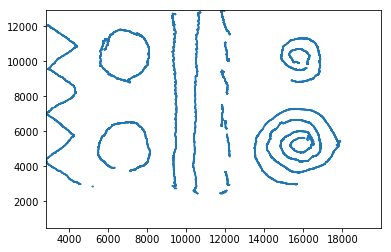

In [59]:
def findElementIn(array, elem):
    for i in range(0, len(array)):
        if array[i] >= elem:            
            return i
    return len(array)

def plotSelect(i):
    i = int(i)
    def plotConfiguration(Show_All_Lines, pokaz_nacisk, timer):
        if Show_All_Lines:
            index = findElementIn(plotObject[i].momentPomiaruAll, int(timer[0])), findElementIn(plotObject[i].momentPomiaruAll, int(timer[1]))
        else:
            index = findElementIn(plotObject[i].momentPomiaru, int(timer[0])), findElementIn(plotObject[i].momentPomiaru, int(timer[1]))
        axes = plt.gca()
        axes.set_xlim([min(plotObject[i].XAll),max(plotObject[i].XAll)])
        axes.set_ylim([min(plotObject[i].YAll),max(plotObject[i].YAll)])
        
        if Show_All_Lines and pokaz_nacisk:
            plt.scatter(plotObject[i].XAll[index[0]:index[1]], plotObject[i].YAll[index[0]:index[1]], c=plotObject[i].naciskKoloryAll[index[0]:index[1]], s=plotObject[i].gruboscAll[index[0]:index[1]])
        elif not Show_All_Lines and pokaz_nacisk:
            plt.scatter(plotObject[i].X[index[0]:index[1]], plotObject[i].Y[index[0]:index[1]], c=plotObject[i].naciskKolory[index[0]:index[1]], s=np.linspace(0.5, 0.5, num=len(plotObject[i].X[index[0]:index[1]])))
        elif Show_All_Lines and not pokaz_nacisk:
            plt.scatter(plotObject[i].XAll[index[0]:index[1]], plotObject[i].YAll[index[0]:index[1]], s=plotObject[i].gruboscAll[index[0]:index[1]])
        elif not Show_All_Lines and not pokaz_nacisk: 
            plt.scatter(plotObject[i].X[index[0]:index[1]], plotObject[i].Y[index[0]:index[1]], s=np.linspace(0.5, 0.5, num=len(plotObject[i].X[index[0]:index[1]])))
        plt.show()
    timerSlider = widgets.IntRangeSlider(min=0,max=plotObject[i].momentPomiaruAll[-1:][0],step=1,value=[0, plotObject[i].momentPomiaruAll[-1:][0]])
    interact(plotConfiguration, Show_All_Lines=False, pokaz_nacisk=False, timer=timerSlider)

interact(plotSelect, i=np.linspace(0, len(mtbFiles)-1, num=len(mtbFiles), dtype=int).tolist())